# Compare HFB responses to speech and non-speech prior to regression on audio features and after

In [1]:
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy.stats import kruskal
import scikit_posthocs as spost
from utils import load_fragment_times, zscore

%matplotlib inline

In [2]:
hdir = '../data/'
speech = load_fragment_times(hdir, 'speech')
nonspeech = load_fragment_times(hdir,'nonspeech')
aud = np.load('../data/audio_envelope_100Hz.npy')
pitch = np.loadtxt('../data/M3_audio_mono_down_pitch_short_edited')
speech_onoff = np.load('../data/speech_on_off_100Hz.npy')
sound_onoff = np.load('../data/sound_on_off_100Hz.npy')

In [3]:
subj = 's1'
x    = np.load('../data/' + subj + '_HD_100Hz_hfb.npy')
pm = np.load('../results/ttest_ecog_speech_nonspeech_'+subj+'_pmask.npz')['pmask_bonf'] # pmask from the first ttest
grid = np.load('../data/' + subj + '_HD_grid.npy')
n = x.shape[-1]

In [4]:
# shift to max correlation lag per fragment for both speech and nonspeech fragments
D = np.load('../results/xcor_'+subj+'_audio_envelope_100Hz_hfb_spearman.npz')
start = 390
r_spe = D['r_spe'][:,:,start:-349]
rm_spe = np.argmax(r_spe, 2)
r_non = D['r_non'][:,:,start:-349]
rm_non = np.argmax(r_non, 2)

maxr_spe = np.zeros(rm_spe.shape)
maxr_non = np.zeros(rm_non.shape)
for i, f in enumerate(rm_spe):
    for ir, r in enumerate(f):
        maxr_spe[i, ir] = r_spe[i, ir][rm_spe[i, ir]]

for i, f in enumerate(rm_non):
    for ir, r in enumerate(f):
        maxr_non[i, ir] = r_non[i, ir][rm_non[i, ir]]

offset = 400 - start
rm_spe = rm_spe - offset
rm_non = rm_non - offset

In [5]:
# select fragments and concatenate over time
x_spe, x_non, a_spe, pitch_spe, a_non, pitch_non, o_spe, o_non = [], [], [], [], [], [], [], []
for ifrag, (spe_frag, non_frag) in enumerate(zip(speech, nonspeech)):
    x_spe.append([])
    x_non.append([])
    a_spe.append(aud[range(spe_frag[0], spe_frag[1])])
    pitch_spe.append(pitch[range(spe_frag[0], spe_frag[1])])
    a_non.append(aud[range(non_frag[0], non_frag[1])])
    pitch_non.append(pitch[range(non_frag[0], non_frag[1])])
    o_spe.append(speech_onoff[range(spe_frag[0], spe_frag[1])]) # on_off based on speech annotations for speech
    o_non.append(sound_onoff[range(non_frag[0], non_frag[1])]) # on_off based on db intensity in praat for nonspeech
    for i in range(n):
        x_spe[-1].append(x[range(spe_frag[0]+rm_spe[ifrag, i], spe_frag[1]+rm_spe[ifrag, i]), i])
        x_non[-1].append(x[range(non_frag[0]+rm_non[ifrag, i], non_frag[1]+rm_non[ifrag, i]), i])

x_spe = np.array(x_spe)
x_non = np.array(x_non)
a_spe = np.array(a_spe)
pitch_spe = np.array(pitch_spe)
a_non = np.array(a_non)
pitch_non = np.array(pitch_non)
o_spe = np.array(o_spe)
o_non = np.array(o_non)

x_spe_c = x_spe.swapaxes(1, 2).reshape((-1, n))
x_non_c = x_non.swapaxes(1, 2).reshape((-1, n))
a_spe_c = a_spe.reshape(-1, )
pitch_spe_c = pitch_spe.reshape(-1, )
a_non_c = a_non.reshape(-1, )
pitch_non_c = pitch_non.reshape(-1, )
o_spe_c = o_spe.reshape(-1, )
o_non_c = o_non.reshape(-1, )

In [6]:
# fit regression
a_spe_cz = zscore(a_spe_c)
pitch_spe_cz = zscore(pitch_spe_c)
a_non_cz = zscore(a_non_c)
pitch_non_cz = zscore(pitch_non_c)
x_spe_mean = np.mean(x_spe_c, axis=0, keepdims=True)
x_spe_std = np.mean(x_spe_c, axis=0, keepdims=True)
temp = zscore(np.vstack([x_spe_c, x_non_c]))
x_spe_cz = temp[:x_spe_c.shape[0]]
x_non_cz = temp[x_spe_c.shape[0]:]

all_regs_non = np.vstack([o_non_c, a_non_cz, pitch_non_cz]).T
all_regs_spe = np.vstack([o_spe_c, a_spe_cz, pitch_spe_cz]).T

x_spe_betas, x_spe_sumres, _, _ = linalg.lstsq(all_regs_spe, x_spe_cz)
x_non_betas, x_non_sumres, _, _ = linalg.lstsq(all_regs_non, x_non_cz)

x_spe_fit = all_regs_spe.dot(x_spe_betas)
x_spe_rsd = x_spe_cz - x_spe_fit
x_non_fit = all_regs_non.dot(x_non_betas)
x_non_rsd = x_non_cz - x_non_fit

x_spe_rsd_f = x_spe_rsd.reshape((speech.shape[0], -1, n))
x_non_rsd_f = x_non_rsd.reshape((nonspeech.shape[0], -1, n))
x_spe_rsd_fm = np.mean(x_spe_rsd_f,1)
x_non_rsd_fm = np.mean(x_non_rsd_f,1)
x_spe_cz_f = x_spe_cz.reshape((speech.shape[0], -1, n))
x_non_cz_f = x_non_cz.reshape((nonspeech.shape[0], -1, n))
x_spe_cz_fm = np.mean(x_spe_cz_f,1)
x_non_cz_fm = np.mean(x_non_cz_f,1)

In [7]:
# kruskal-wallis test
temp = np.vstack([np.mean(x_spe_cz_fm[:, pm], 0), 
                  np.mean(x_spe_rsd_fm[:, pm], 0), 
                  np.mean(x_non_cz_fm[:, pm], 0), 
                  np.mean(x_non_rsd_fm[:, pm], 0)])
H, p_omn = kruskal(temp[0], temp[1], temp[2], temp[3])
spost.posthoc_dunn(temp)

,1,2,3,4
1,-1.000000e+00,0.010517,4.279723e-13,4.662510e-08
2,1.051684e-02,-1.000000,2.758190e-06,3.668227e-03
3,4.279723e-13,0.000003,-1.000000e+00,7.463772e-02
4,4.662510e-08,0.003668,7.463772e-02,-1.000000e+00


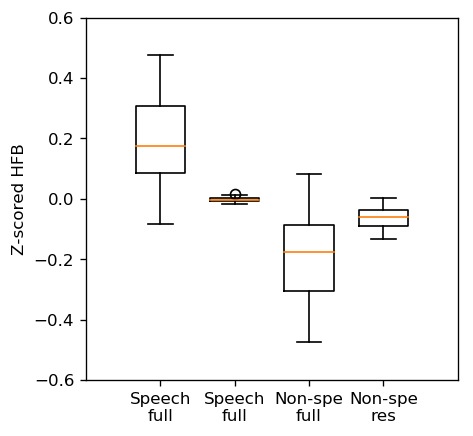

In [11]:
# boxplot for s1
plt.figure(figsize=(4, 4), dpi=120)
plt.boxplot([np.mean(x_spe_cz[:, pm], 0), 
             np.mean(x_spe_rsd_fm[:, pm], 0), 
             np.mean(x_non_cz[:, pm], 0), 
             np.mean(x_non_rsd_fm[:, pm],0)], positions = [.5, 1, 1.5, 2], widths=.33)
plt.xlim(0, 2.5)
plt.ylim(-.6, .6)
plt.xticks([.5, 1, 1.5, 2], ['Speech\nfull', 'Speech\nfull', 'Non-spe\nfull', 'Non-spe\nres'])
plt.ylabel('Z-scored HFB')
plt.show()